In [68]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
from arcs.generate import GraphGenerator

graph = GraphGenerator().from_file(
    filename='../app/data/scan_dft_data.json',
    temperature=248,
    pressure=20,
    max_reaction_length=5
)

/Users/badw/github-projects/arcs/arcs/generate.py:255: RuntimeWarning: overflow encountered in exp
  K = np.exp(


/Users/badw/miniconda3/envs/py311/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


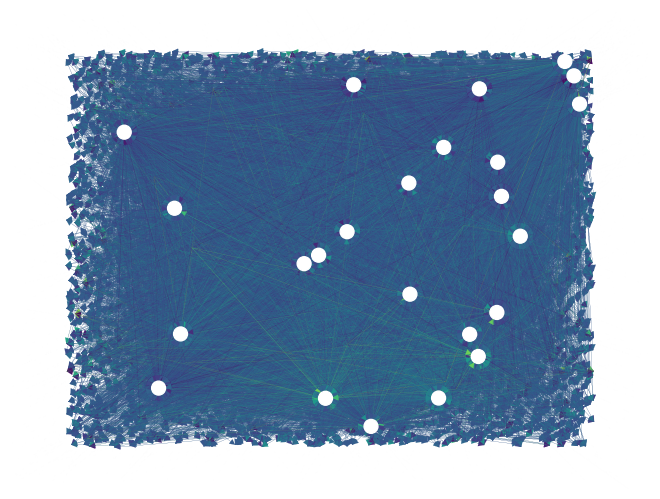

In [77]:
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np 
G = graph 

node_colours= []
node_sizes = []
for node in list(G.nodes):
    if isinstance(node,int):
        node_colours.append('black')
        node_sizes.append(0)
    else:
        node_colours.append('white')
        node_sizes.append(100)

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
vmin = np.min(weights)
vmax = np.max(weights)
cmap = plt.cm.viridis

nx.draw_random(G,node_color=node_colours,node_size=node_sizes,edgelist=edges,edge_color=weights,width=0.1,edge_cmap=cmap,vmin=vmin,vmax=vmax)

In [78]:
#from arcs.traversal import Traversal
#from arcs.generate import GenerateInitialConcentrations
#import pandas as pd #
#gic = GenerateInitialConcentrations(graph=graph).update_ic(
#    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
#    )#
#t = Traversal(graph=graph)#
#t.rank_small_reactions_higher = {'option':True,'by_coefficients':True}
#random_compounds = t.get_weighted_random_compounds(gic)
#print(random_compounds)
#random_reactions = t.get_weighted_reaction_rankings(random_compounds)
#random_reactions 
#for k in random_reactions:
#    print(graph.nodes()[k]['reaction']['reaction_string'])

In [88]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)

t.rank_small_reactions_higher = {'option':True,'by_coefficients':True}

data = t.sample(initial_concentrations=gic,ncpus=10,nsamples=500,progress_bar=True)

  0%|          | 0/500 [00:00<?, ?it/s]

In [120]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling()
new_data = analysis.reduce_data_by_minimum_path_length(data,4)
pd.Series(analysis.reaction_statistics(new_data)).sort_values(ascending=False)

2 H2O + 1 SO2 = 1 H2 + 1 H2SO4      195
2 H2O = 1 O2 + 2 H2                 166
1 H2S + 2 O2 = 1 H2SO4              146
1 H2O + 1 H2SO3 = 1 H2 + 1 H2SO4    115
1 H2O + 1 SO2 = 1 H2SO3             105
1 H2S + 1 O2 = 1 H2 + 1 SO2          87
1 O2 + 2 H2SO3 = 2 H2SO4             86
1 H2S + 1 H2SO4 = 2 H2 + 2 SO2       58
1 H2S + 3 H2SO4 = 4 H2SO3            40
8 H2S = 8 H2 + 1 S8                  10
1 O2 + 2 H2 + 2 SO2 = 2 H2SO3        10
1 O2 + 1 H2 + 1 SO2 = 1 H2SO4         9
dtype: int64

In [122]:
average_data = analysis.average_sampling(new_data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(5)
average_data.sort_values(by='diff',inplace=True)
average_data

,initial,mean,diff,std
H2O,30.0,18.939646,-11.060354,6.416085
SO2,10.0,1.587147,-8.412853,3.655879
O2,10.0,7.302827,-2.697173,3.909154
H2S,10.0,9.281497,-0.718503,1.827660
S8,0.0,0.021522,0.021522,0.152792
H2,0.0,2.474282,2.474282,4.306128
H2SO3,0.0,2.552138,2.552138,4.350908
H2SO4,0.0,6.405998,6.405998,5.272432


<Axes: >

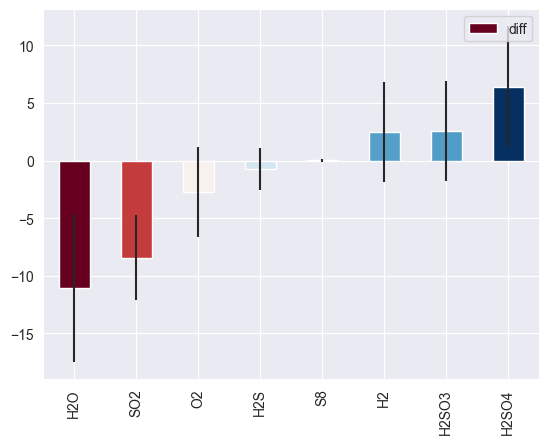

In [123]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

In [ ]:
import networkx as nx 
from pyvis.network import Network 


reaction_statistics = analysis.reaction_statistics(data)

rs = {}
reactions = [graph.nodes()[x]['reaction'] for x in graph.nodes() if isinstance(x,int)]
for i,reaction in enumerate(reactions):
    if reaction['reaction_string'] in list(reaction_statistics):
        rs[i] = reaction 
        rs[i]['frequency'] = reaction_statistics[reaction['reaction_string']]
        

G = nx.MultiDiGraph(directed=True)

for i,reaction in rs.items():
    G.add_weighted_edges_from(
                [compound,str(i),1] for compound in reaction['reactants']
                ) #reactants -> reaction
    G.add_weighted_edges_from(
                [str(i),compound,1] for compound in reaction['products']
                ) #reaction -> products
            
frequency = {str(i):reaction['frequency'] for i,reaction in rs.items()}

nx.set_node_attributes(G,frequency,name='frequency')

g = Network(height=800,width=800,notebook=False,directed=True,neighborhood_highlight=True)
g.from_nx(G,show_edge_weights=False)
g.save_graph('graph.html')

effect of adding NO2

In [87]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic(
    #{'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':0}
    {'H2O':30,'O2':10,'SO2':10,'H2S':10,'NO2':10}
    #{'H2O':30,'SO2':10}
    )

t = Traversal(graph=graph)

t.rank_small_reactions_higher = {'option':True,'by_coefficients':True}
print(t.rank_small_reactions_higher)

data = t.sample(initial_concentrations=gic,ncpus=10,nsamples=500,progress_bar=True)

{'option': True, 'by_coefficients': True}


  0%|          | 0/500 [00:00<?, ?it/s]

In [50]:
from arcs.analysis import AnalyseSampling
import pandas as pd 

analysis = AnalyseSampling() #use_markdown=True,use_latex=True)
pd.Series(analysis.reaction_statistics(data)).sort_values(ascending=False)

8 O2 + 1 S8 = 8 SO2                67
1 H2 + 1 SO2 = 1 O2 + 1 H2S        43
1 H2O + 1 NO2 + 1 NO = 2 HNO2      30
1 O2 + 2 NO = 2 NO2                27
2 H2 + 1 O2 = 2 H2O                20
2 O2 + 1 N2 = 2 NO2                20
1 H2O + 1 SO2 = 1 H2SO3            14
1 H2O + 2 NO2 = 1 HNO3 + 1 HNO2    13
2 O2 + 1 H2S = 1 H2SO4             10
1 H2 + 1 NO2 = 1 H2O + 1 NO        10
dtype: int64

In [51]:
average_data = analysis.average_sampling(data)
average_data = average_data.loc[~(average_data==0).all(axis=1)]
average_data.round(5)
average_data.sort_values(by='diff',inplace=True)
average_data

,initial,mean,diff,std
H2S,10.0,6.360338,-3.639662,4.799441
NO2,10.0,7.125984,-2.874016,4.534439
SO2,10.0,7.375923,-2.624077,5.171009
H2SO3,0.0,0.000144,0.000144,0.000379
H2SO4,0.0,0.371945,0.371945,1.840902
N2,0.0,0.393701,0.393701,1.349323
H2O,30.0,30.531352,0.531352,3.851639
HNO3,0.0,0.649606,0.649606,1.684403
HNO2,0.0,0.649606,0.649606,1.684403
S8,0.0,0.736456,0.736456,0.627888


<Axes: >

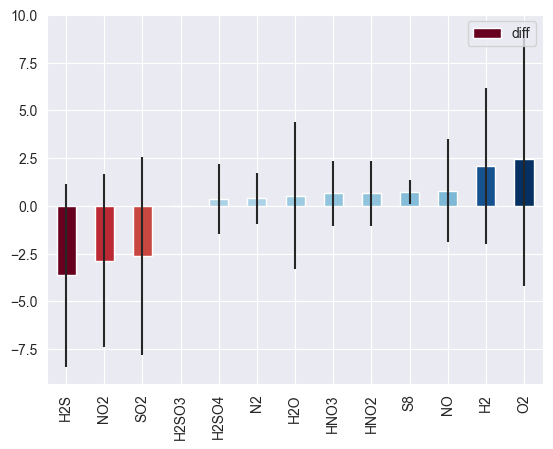

In [52]:
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_style('darkgrid')
sns.set_palette('pastel')


norm = colors.Normalize(vmin=average_data['diff'].min(), vmax=average_data['diff'].max())
cmap = cm.RdBu  # or any other colormap

bar_colors = [cmap(norm(value)) for value in average_data['diff']]

average_data.plot.bar(y='diff',yerr='std',color=bar_colors)

testing

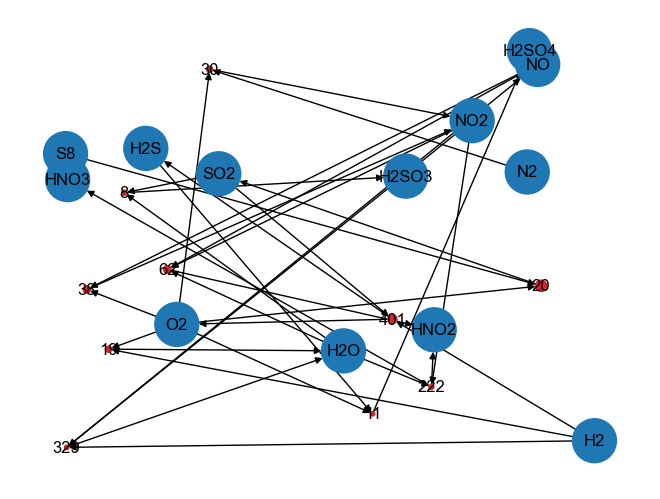

In [58]:
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np 
import seaborn as sns 
sns.set_palette('pastel')

node_colours= []
node_sizes = []
for node in list(G.nodes):
    try:
        int(node)
        node_colours.append('Tab:Red')
        try:
            node_sizes.append(G.nodes()[node]['frequency'])
        except Exception as e :
            print(e)
    except Exception as e:
        node_colours.append('Tab:Blue')
        node_sizes.append(1000)

nx.draw_random(G,node_color=node_colours,node_size=node_sizes,with_labels=True)

In [59]:
from pyvis.network import Network 
import networkx as nx 
g = Network(height=800,width=800,notebook=False,directed=True,neighborhood_highlight=True)
g.from_nx(G,show_edge_weights=False)
g.save_graph('graph.html')

### Speed Test 

In [ ]:
from arcs.traversal import Traversal
from arcs.generate import GenerateInitialConcentrations

gic = GenerateInitialConcentrations(graph=graph).update_ic({'H2O':100,'H2':30,'O2':50,'H2S':100,'NO2':200,'N2':300})
t = Traversal(graph=graph)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=1)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=2)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=4)

In [ ]:
data = t.sample(initial_concentrations=gic,ncpus=10)

In [ ]:
t.random_walk(gic)